In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
from epics import PV, caget, caput

import os
os.environ['EPICS_CA_ADDR_LIST'] = 'localhost'
os.environ['EPICS_CA_AUTO_ADDR_LIST'] = 'NO'

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['font.size'] = 8

In [8]:
caput('USPAS:LLRF:Loop:AmpSetp', 30000)
caput('USPAS:LLRF:reg_pulse_mode', 1)
caput('USPAS:LLRF:reg_pulse_high_len', 60000)
caput('USPAS:LLRF:ACQ_DECIM', 50)

1


The ADC5 waveform will show the step response of the crystal.
It is expected to have a result like the following screenshot.

![pulse1](pulse1.png)

Explain the reason of ringing of the ADC5 amplitude and phase waveforms.
Explain the spirals in IQ waveform plot.


## Find cavity detune through falling edge analysis

In [9]:

fs = 1e6 / PV('USPAS:LLRF:ACQ_SAMP_PERIOD').value
pv_twf = PV('USPAS:LLRF:CavCel:TWF')
pv_awf = PV('USPAS:LLRF:CavCel:AWF')
pv_pwf = PV('USPAS:LLRF:CavCel:PWF')
pv_iwf = PV('USPAS:LLRF:CavCel:IWF')
pv_qwf = PV('USPAS:LLRF:CavCel:QWF')

df = pd.DataFrame({
    'T [µs]': pv_twf.value,
    'amp': pv_awf.value,
    'phs': pv_pwf.value,
    'i': pv_iwf.value, 'q': pv_qwf.value})
df.set_index('T [µs]');

<AxesSubplot: >

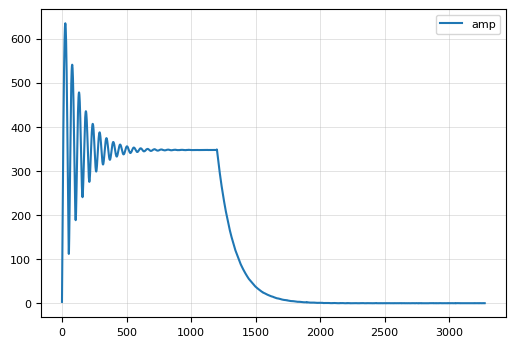

In [10]:
df[['amp']].plot()

<AxesSubplot: >

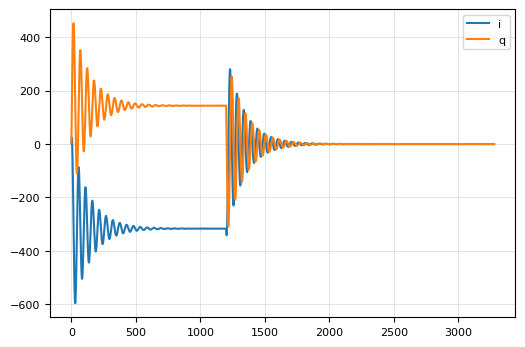

In [11]:
df[['i', 'q']].plot()

<AxesSubplot: xlabel='i'>

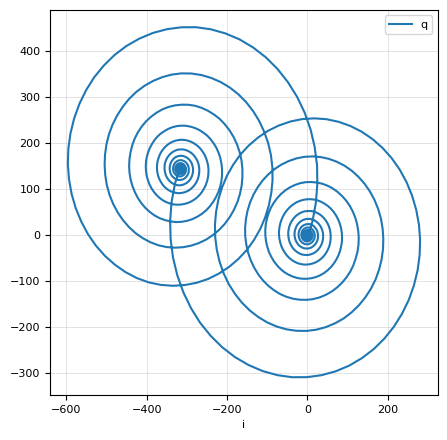

In [12]:
df[['i', 'q']].plot(x='i', figsize=(5,5))

## Extract detune frequency from falling edge

Confirm falling edge starts from 1200 µs:

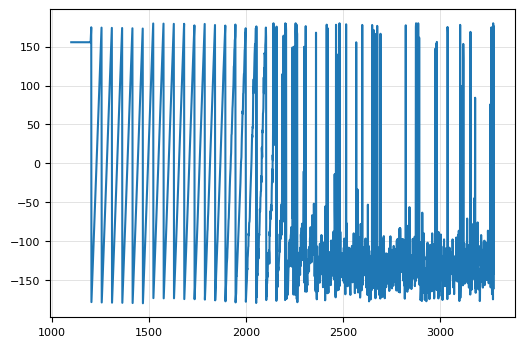

In [13]:
df[1100:]['phs'].plot();

In [14]:
fall_wf = df[1200:2200]['phs']
f, pxx_den = signal.periodogram(fall_wf, fs, nfft=8192)
f_peak = f[np.argmax(pxx_den)]

Peak freq: 1879.88 Hz


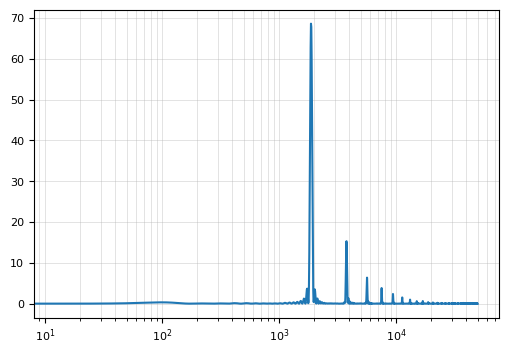

In [15]:
plt.semilogx(f, pxx_den)
print(f'Peak freq: {f_peak:.2f} Hz')

Therefore cavity detune is at 1.8 kHz.

From crystal characterization lab, we know the resoance frequency is around 19.998 MHz, so this measurement confirms that the exact frequency is at 19.9982 MHz.

## Measure the crystal bandwidth.
Compare the results to the one you measured on the first day.

## Adjust LLRF LO DDS to *tune* crystal

In [16]:
import sys
sys.path.append('..')
from dds.dds import calc_dds, reg2freq

In [17]:
num = 4 * (1 - f_peak / 20e6)  # offset from 4
ph, pl, modulo = calc_dds(num, 23)
fdds = reg2freq(ph, pl, modulo, 115e6)
print(f'New DDS freq: {fdds/1e6:.3f} MHz')

major resolution:  109.673 Hz
minor resolution:  0.027 Hz
modulo resolution: 0.024 Hz
New DDS freq: 19.998 MHz


In [18]:
new_ph_step = (ph << 12) | pl

Adjust DDS frequency!

In [19]:
phase_step_pv = PV('USPAS:LLRF:reg_dds_phase_step')
phase_step_pv.value = new_ph_step

![pulse2](pulse2.png)

## Close amplitude and phase loop

1. Disable pulse mode
2. Adjust amplitude setpoint to 2000
3. Set both loops Ki, Kp gain to 1
4. Reset both loops

![closed_loop](close_loop.png)

In [20]:
caput('USPAS:LLRF:reg_pulse_mode', 0)
caput('USPAS:LLRF:Loop:AmpSetp', 2000)
caput('USPAS:LLRF:reg_Kp_amp', 100)
caput('USPAS:LLRF:reg_Ki_amp', 1)
caput('USPAS:LLRF:reg_amp_loop_reset', 1)
caput('USPAS:LLRF:reg_amp_loop_reset', 0)
caput('USPAS:LLRF:reg_amp_loop_enable', 1)

caput('USPAS:LLRF:Loop:PhsSetp', 1)
caput('USPAS:LLRF:reg_Kp_phs', 100)
caput('USPAS:LLRF:reg_Ki_phs', 1)
caput('USPAS:LLRF:reg_phs_loop_reset', 1)
caput('USPAS:LLRF:reg_phs_loop_reset', 0)
caput('USPAS:LLRF:reg_phs_loop_enable', 1)

1

Increase integral and proportional gain and observe loop stability.